# Flight Price Prediction Using Random Forest Model With Deployment

In [1]:
#Importing required libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor , ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RandomizedSearchCV , train_test_split

In [2]:
#Importing dataset

df = pd.read_excel("Data_Train.xlsx")

df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
#Dropping Missing Values

df.dropna(inplace = True)

In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
#Converting string values in columns "Date_of_Journey", "Dep_Time" and"Arrival_Time" to Datetime

df["Journey_month"] = pd.to_datetime(df["Date_of_Journey"]).dt.month
df["Journey_day"] = pd.to_datetime(df["Date_of_Journey"]).dt.day

df["Dep_Time_hr"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_Time_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute

df["Arrival_Time_hr"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arrival_Time_min"] = pd.to_datetime(df["Arrival_Time"]).dt.minute

c:\Users\rahul\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '24/03/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\rahul\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '24/06/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\rahul\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '27/05/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\rahul\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '18/04/2019' in DD/MM/YYYY format. Provide format or specif

In [6]:
#Dropping insignificant columns 


df.drop(["Date_of_Journey" , "Dep_Time" , "Arrival_Time","Additional_Info","Route"] , axis =1 , inplace = True)

In [7]:
#Converting Categorical Features into numerical form using LabelEncoder()

le = LabelEncoder()

df["Source"] = le.fit_transform(df["Source"])
df["Destination"] = le.fit_transform(df["Destination"])

In [8]:
# Determining no. of flights for different Airline companies in dataset 

print(df.Airline.value_counts())   
print(" ")

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64
 


In [9]:
#mapping no. of stops for dataset 

stop = {
    "non-stop":0,
    "1 stop":1,
    "2 stops":2,
    "3 stops":3,
    "4 stops":4
}

df.loc[: , "Total_Stops"] = df["Total_Stops"].map(stop)    

In [10]:
#Loading dataset
df.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_month,Journey_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min
0,IndiGo,0,5,2h 50m,0,3897,3,24,22,20,1,10
1,Air India,3,0,7h 25m,2,7662,1,5,5,50,13,15
2,Jet Airways,2,1,19h,2,13882,9,6,9,25,4,25
3,IndiGo,3,0,5h 25m,1,6218,12,5,18,5,23,30
4,IndiGo,0,5,4h 45m,1,13302,1,3,16,50,21,35


In [11]:
#change of duration into hr and min
#train

duration = list(df["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))

In [12]:
df["Duration_hours"] = duration_hours
df["Duration_mins"] = duration_mins

In [13]:
df.head(8)    #Loading the modified data

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_month,Journey_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min,Duration_hours,Duration_mins
0,IndiGo,0,5,2h 50m,0,3897,3,24,22,20,1,10,2,50
1,Air India,3,0,7h 25m,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,2,1,19h,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,3,0,5h 25m,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,0,5,4h 45m,1,13302,1,3,16,50,21,35,4,45
5,SpiceJet,3,0,2h 25m,0,3873,6,24,9,0,11,25,2,25
6,Jet Airways,0,5,15h 30m,1,11087,12,3,18,55,10,25,15,30
7,Jet Airways,0,5,21h 5m,1,22270,1,3,8,0,5,5,21,5


In [14]:
#Dropping the "Duration" column from dataset as it is irrelevant now

df.drop(["Duration"] , axis =1 , inplace =True)

In [15]:
#mapping

stop = {
    "Jet Airways":1,
    "IndiGo":2,
    "Air India":3,
    "Multiple carriers":4,
    "SpiceJet":5 , "Vistara":6 ,"Air Asia":7 , "GoAir":8, 
}

df.loc[: , "Airline"] = df["Airline"].map(stop)

In [16]:
for name in stop.values():
    print(name)

1
2
3
4
5
6
7
8


In [17]:
df.isna().sum()

Airline             23
Source               0
Destination          0
Total_Stops          0
Price                0
Journey_month        0
Journey_day          0
Dep_Time_hr          0
Dep_Time_min         0
Arrival_Time_hr      0
Arrival_Time_min     0
Duration_hours       0
Duration_mins        0
dtype: int64

In [18]:
df = df[df.Airline != 'Trujet']

df = df[df.Airline != 'Multiple carriers Premium economy']
df = df[df.Airline != 'Jet Airways Business']
df = df[df.Airline != 'Vistara Premium economy']

In [19]:
df.isna().sum()

Airline             23
Source               0
Destination          0
Total_Stops          0
Price                0
Journey_month        0
Journey_day          0
Dep_Time_hr          0
Dep_Time_min         0
Arrival_Time_hr      0
Arrival_Time_min     0
Duration_hours       0
Duration_mins        0
dtype: int64

In [20]:
df.dropna(inplace = True)

In [21]:
df.isna().sum()

Airline             0
Source              0
Destination         0
Total_Stops         0
Price               0
Journey_month       0
Journey_day         0
Dep_Time_hr         0
Dep_Time_min        0
Arrival_Time_hr     0
Arrival_Time_min    0
Duration_hours      0
Duration_mins       0
dtype: int64

In [22]:
x = df.drop(["Price"], axis=1)

In [23]:
x.head()

,Airline,Source,Destination,Total_Stops,Journey_month,Journey_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min,Duration_hours,Duration_mins
0,2.0,0,5,0,3,24,22,20,1,10,2,50
1,3.0,3,0,2,1,5,5,50,13,15,7,25
2,1.0,2,1,2,9,6,9,25,4,25,19,0
3,2.0,3,0,1,12,5,18,5,23,30,5,25
4,2.0,0,5,1,1,3,16,50,21,35,4,45


In [24]:
y = df['Price']

In [25]:
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [26]:

x_train , x_test , y_train , y_test = train_test_split(x,y,random_state = 100 , test_size = 0.3)

In [27]:
feat = ExtraTreesRegressor()
feat.fit(x_train , y_train)

ExtraTreesRegressor()

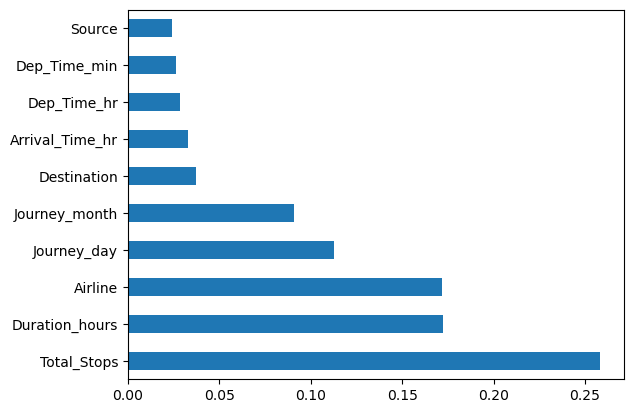

In [28]:
features = pd.Series( feat.feature_importances_ , index = x_train.columns )
features.nlargest(10).plot(kind = "barh")
plt.show()

From the plot above, we can clearly see that the feature **Total_Stops** has the highest importance.

In [29]:
##create model
lr = LinearRegression()
xgb = XGBRegressor()
rfr = RandomForestRegressor()
dt = DecisionTreeRegressor()

In [30]:
print(lr.fit(x_train , y_train))
print(xgb.fit(x_train , y_train))
print(rfr.fit(x_train , y_train))
print(dt.fit(x_train , y_train))

LinearRegression()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
RandomForestRegressor()
DecisionTreeRegressor()


In [31]:
#train acc

print(r2_score(lr.predict(x_train) , y_train))
print(r2_score(xgb.predict(x_train) , y_train))
print(r2_score(rfr.predict(x_train) , y_train))
print(r2_score(dt.predict(x_train) , y_train))

-0.11688560203520115
0.9286161967213169
0.9499701372695092
0.9703741070907215


c:\Users\rahul\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

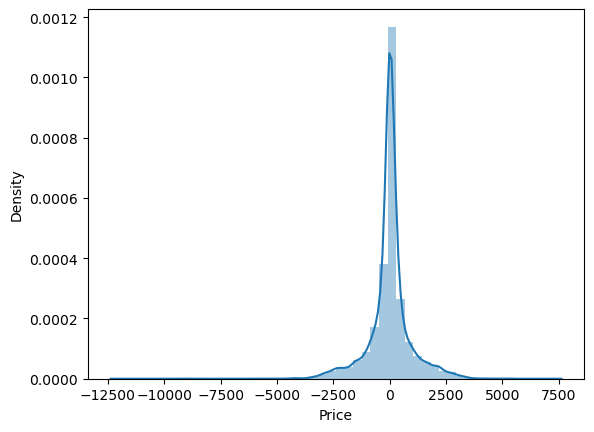

In [32]:
#checking distribution on the train dataset
sb.distplot(rfr.predict(x_train) - y_train)

We are getting a perfect **normal distribution curve** which is the ideal case.

c:\Users\rahul\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

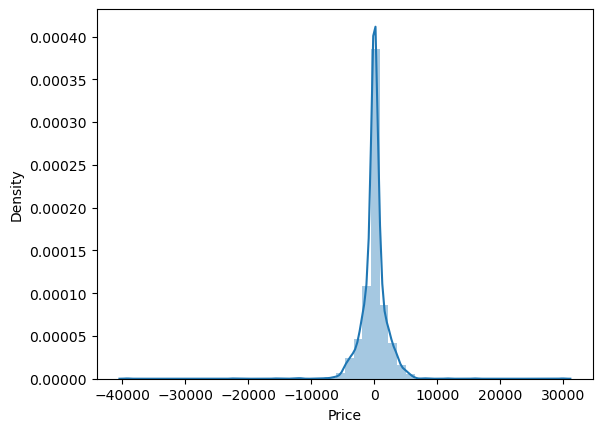

In [33]:
#checking distribution on the test dataset
sb.distplot(rfr.predict(x_test) - y_test)

For the test dataset also, we are getting a **normal distribution curve** which means that our model **Random Forest Regressor** is performing correctly

## Hyperparameter Tuning

In [34]:

rf_p = {
    
    "min_samples_split": list(range(2,11)),
    "min_samples_leaf" : list(range(1,10)),
    "max_depth":list(range(1,200)),
    "n_estimators": list(range(1,500))
}

dt_p = {
    "criterion":["mse"],
    "min_samples_split": list(range(2,11)),
    "min_samples_leaf" : list(range(1,10)),
    "max_depth":list(range(1,200))
}

xgb_p = {
    "learning_rate" : [0.1,0.2,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.5],
    "max_depth" : list(range(1,200)),
    "booster" : ['gbtree', 'gblinear' ,'dart'],
    "min_child_weight" : list(range(1,20)),
    "n_estimators" : list(range(1,200))
}

In [35]:
rscv = RandomizedSearchCV(rfr , param_distributions=rf_p , cv =10 , n_iter=10  ,n_jobs = -1 , verbose = 10)

In [36]:
rscv.fit(x,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 

In [37]:
rscv.best_estimator_

RandomForestRegressor(max_depth=13, min_samples_split=9, n_estimators=111)

In [38]:
rfr =RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0,
                      min_samples_leaf=3, min_samples_split=9,
                      min_weight_fraction_leaf=0.0, n_estimators=69,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [39]:
rfr.fit(x_train , y_train)
xgb.fit(x_train , y_train)
dt.fit(x_train , y_train)

c:\Users\rahul\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


DecisionTreeRegressor()

In [40]:
print(r2_score(rfr.predict(x_test) , y_test))
print(r2_score(xgb.predict(x_test) , y_test))
print(r2_score(dt.predict(x_test) , y_test))

0.7823008429632186
0.7735574129485412
0.6749192907190393


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [42]:
#Saving the model in a pickle file

file = open('pipe.pkl', "wb")
pickle.dump(rfr , file)

In [43]:
model = open('pipe.pkl', "rb")
forest = pickle.load(model)

In [44]:
#testing pickle file
z = forest.predict(x_test.iloc[1:2 , :])

In [45]:
for j in z:
    print(j)

13079.263671859751


## Conclusion

Our model **Random Forest Regressor** performed well on the prediction with an **accuracy of 95% on the train data and about 80% on the test data**  